In [110]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits,ascii
import pandas as pd
import cmasher as cmr
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u

In [111]:
sample = pd.read_csv("MAGPI_csv/MAGPI_kinemetry_sample.csv")
sample = sample[sample["v_asym_g"]/sample["v_asym_g_err"]>3]
sample = sample[sample["v_asym_s"]/sample["v_asym_s_err"]>3]
prospect = pd.read_csv("MAGPI_csv/MAGPI_ProSpectCat_v0.1.csv")
ssp = pd.read_csv("MAGPI_csv/MAGPI_ApertureSpectra_StellarPops_V1.0_SPV.csv")
bpt = pd.read_csv("MAGPI_csv/MAGPI_kinemetry_sample_BPT.csv")
prospect= prospect[prospect["MAGPIID"].isin(sample["MAGPIID"])]
bpt= bpt[bpt["MAGPIID"].isin(sample["MAGPIID"])]
ssp= ssp[ssp["MAGPIID"].isin(sample["MAGPIID"])]

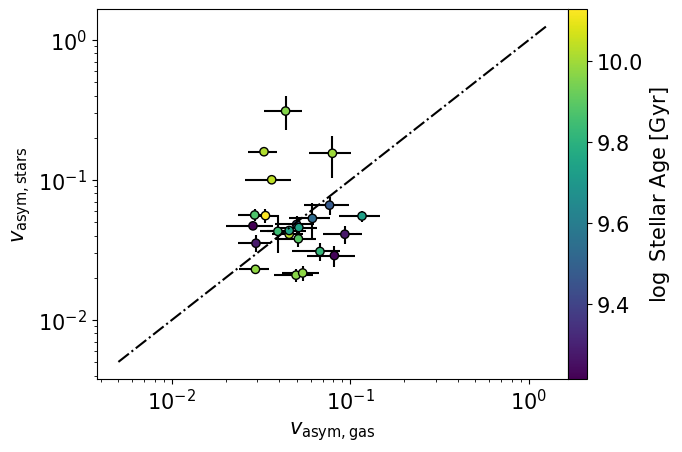

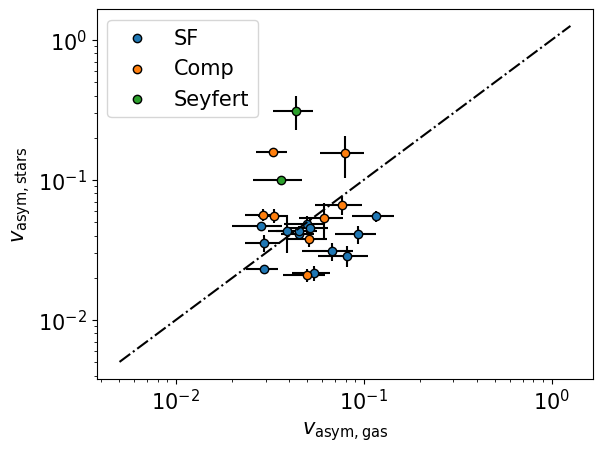

In [112]:
vg = sample["v_asym_g"].to_numpy()
vg_err = sample['v_asym_g_err'].to_numpy()
vs = sample["v_asym_s"].to_numpy()
vs_err = sample["v_asym_s_err"].to_numpy()

fig,ax = plt.subplots()
p=ax.scatter(vs,vg,ec="k",c=ssp["logage_MW_2re"].to_numpy(),zorder=2)
ax.errorbar(vs,vg,xerr=vs_err,yerr=vg_err,fmt=".k",zorder=1)
ax.plot(np.logspace(-2.3,0.1),np.logspace(-2.3,0.1),ls='dashdot',color="k")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$v_{\rm asym,gas}$")
ax.set_ylabel(r"$v_{\rm asym,stars}$")
plt.colorbar(p,ax=ax,label=r"$\log$ Stellar Age [Gyr]",pad=0,fraction=0.05)
plt.show()

fig,ax = plt.subplots()
for i,lab in zip([1,0,2],["SF","Comp","Seyfert"]):
    ax.scatter(vs[bpt['type(sf+AGN=0, sf=1, sy=2, ln=3)']==i],vg[bpt["type(sf+AGN=0, sf=1, sy=2, ln=3)"]==i],
               ec="k",zorder=2,label=lab)
    ax.errorbar(vs[bpt['type(sf+AGN=0, sf=1, sy=2, ln=3)']==i],vg[bpt['type(sf+AGN=0, sf=1, sy=2, ln=3)']==i],
                xerr=vs_err[bpt['type(sf+AGN=0, sf=1, sy=2, ln=3)']==i],
                yerr=vg_err[bpt['type(sf+AGN=0, sf=1, sy=2, ln=3)']==i],fmt=".k",zorder=1)
ax.plot(np.logspace(-2.3,0.1),np.logspace(-2.3,0.1),ls='dashdot',color="k")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$v_{\rm asym,gas}$")
ax.set_ylabel(r"$v_{\rm asym,stars}$")
ax.legend()
plt.show()

/var/folders/nl/v2f_l95j0jx701ctszdv_thr0000gp/T/ipykernel_91357/1494097953.py:19: RuntimeWarning: divide by zero encountered in log10
  if 0.5 > (np.log10(y) - np.log10((x**0.712)*(10**-7.293))) > -1:
/var/folders/nl/v2f_l95j0jx701ctszdv_thr0000gp/T/ipykernel_91357/1494097953.py:21: RuntimeWarning: divide by zero encountered in log10
  if (np.log10(y) - np.log10((x**0.712)*(10**-7.293))) > 0.5:
/var/folders/nl/v2f_l95j0jx701ctszdv_thr0000gp/T/ipykernel_91357/1494097953.py:23: RuntimeWarning: divide by zero encountered in log10
  if (np.log10(y) - np.log10((x**0.712)*(10**-7.293))) < -1:
/Volumes/DS/MAGPI/venv/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3648: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err
/var/folders/nl/v2f_l95j0jx701ctszdv_thr0000gp/T/ipykernel_91357/1494097953.py:51: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor r

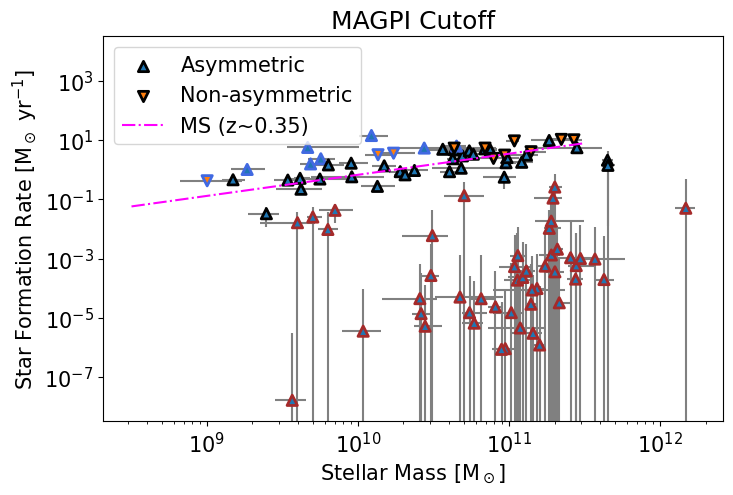

In [113]:
xx = np.logspace(8.5,11.5, 55)
MS = (xx**0.712)*(10**-7.293)

sample = pd.read_csv("MAGPI_csv/MAGPI_kinemetry_sample.csv")
prospect = pd.read_csv("MAGPI_csv/MAGPI_ProSpectCat_v0.1.csv")
ssp = pd.read_csv("MAGPI_csv/MAGPI_ApertureSpectra_StellarPops_V1.0_SPV.csv")
bpt = pd.read_csv("MAGPI_csv/MAGPI_kinemetry_sample_BPT.csv")
prospect= prospect[prospect["MAGPIID"].isin(sample["MAGPIID"])]
mass = prospect["StellarMass_median"].to_numpy()
mass_err_16 = mass-prospect["StellarMass_16"].to_numpy()
mass_err_84 = prospect["StellarMass_84"].to_numpy()-mass
bpt= bpt[bpt["MAGPIID"].isin(sample["MAGPIID"])]
ssp= ssp[ssp["MAGPIID"].isin(sample["MAGPIID"])]
SFR = bpt["SFR, dust corrected"].to_numpy()
SFR_err = bpt["SFR_err"].to_numpy()
asym = sample["v_asym_s"].to_numpy()
D_SFR = []
for x,y in zip(mass,SFR):
    if 0.5 > (np.log10(y) - np.log10((x**0.712)*(10**-7.293))) > -1:
        D_SFR.append(1) # Star Forming
    if (np.log10(y) - np.log10((x**0.712)*(10**-7.293))) > 0.5:
        D_SFR.append(2) # Starbursting
    if (np.log10(y) - np.log10((x**0.712)*(10**-7.293))) < -1:
        D_SFR.append(0)
colors=[]
for i in D_SFR:
    if i==1:
        colors.append("k")
    if i==2:
        colors.append("royalblue")
    if i==0:
        colors.append("brown")
colors=np.array(colors)
plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(figsize=(8,5))
ax.scatter(mass[asym>0.04],SFR[asym>0.04], zorder=2, ec=colors[asym>0.04], label="Asymmetric",s=55,linewidths=1, marker="^",lw=2)
ax.errorbar(mass[asym>0.04],SFR[asym>0.04],xerr=np.array([mass_err_16[asym>0.04],mass_err_84[asym>0.04]]),yerr=SFR_err[asym>0.04], c='gray', zorder=1, ls="")
ax.scatter(mass[asym<0.04],SFR[asym<0.04], zorder=2, ec=colors[asym<0.04], label="Non-asymmetric",s=55, linewidths=1, marker="v",lw=2)
ax.errorbar(mass[asym<0.04],SFR[asym<0.04],xerr=np.array([mass_err_16[asym<0.04],mass_err_84[asym<0.04]]), yerr=SFR_err[asym<0.04], c='gray', zorder=1, ls="")
ax.plot(xx,MS, c="magenta", ls="dashdot", label="MS (z~0.35)")
#ax.plot(xx,MS*0.1, c="magenta", ls="dashdot")
#ax.plot(xx,MS*10, c="magenta", ls="dashdot")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(10**(-8.5),10**(4.5))
ax.set_xlabel("Stellar Mass [M$_\odot$]")
ax.set_ylabel("Star Formation Rate [M$_\odot$ yr$^{-1}$]")
ax.legend(loc="upper right")
ax.set_title("MAGPI Cutoff")
for i in range(2):
    ax.legend_.legendHandles[i].set_edgecolor("k")
plt.savefig("plots/paper2/SFMS_asym_Ha.pdf", bbox_inches="tight")

/var/folders/nl/v2f_l95j0jx701ctszdv_thr0000gp/T/ipykernel_91357/2264821170.py:62: RuntimeWarning: divide by zero encountered in log10
  ax2.hist(np.log10(re2), label="All Galaxies", color="k", alpha=0.2, zorder=1,bins=np.arange(1,4,0.25))
/var/folders/nl/v2f_l95j0jx701ctszdv_thr0000gp/T/ipykernel_91357/2264821170.py:62: RuntimeWarning: invalid value encountered in log10
  ax2.hist(np.log10(re2), label="All Galaxies", color="k", alpha=0.2, zorder=1,bins=np.arange(1,4,0.25))


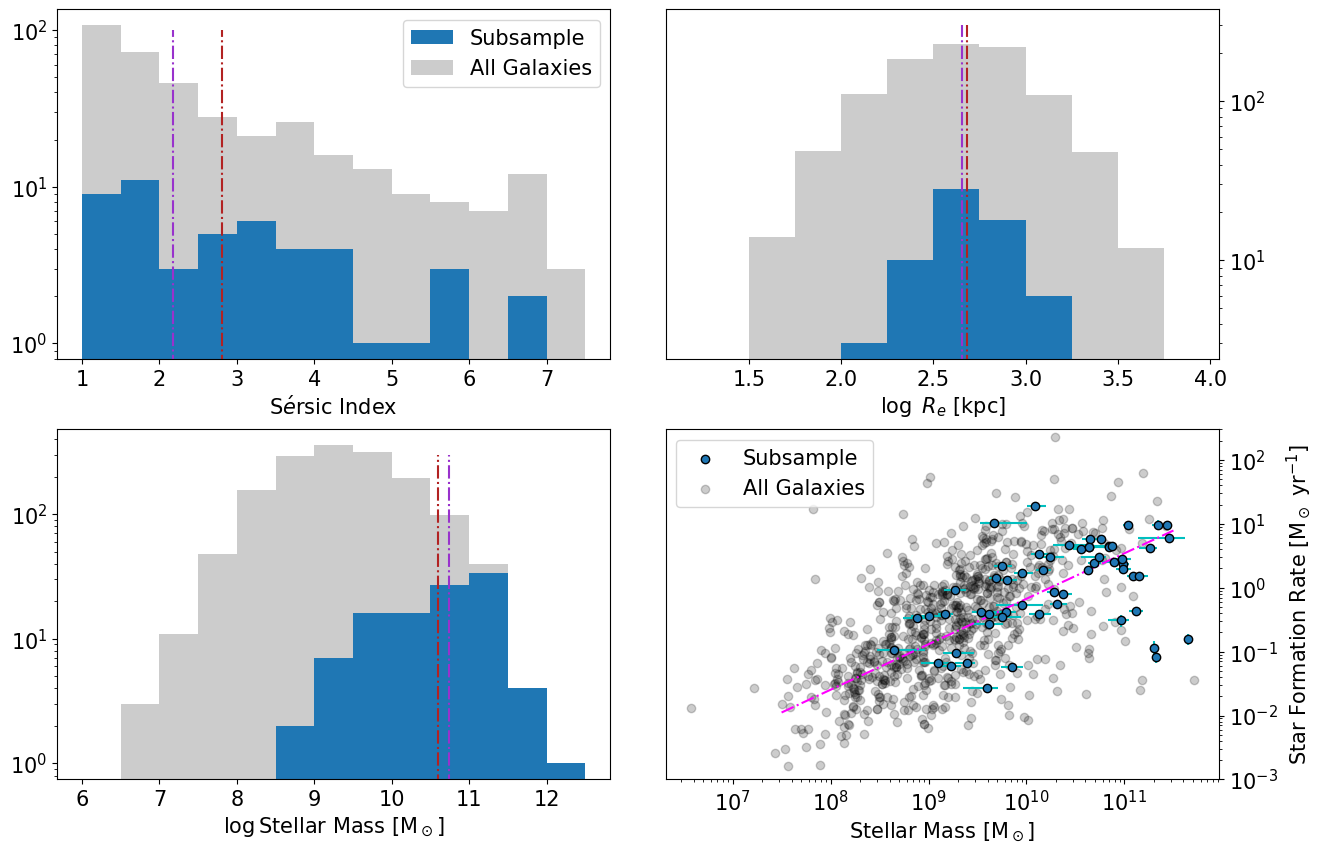

In [114]:
#sample = pd.read_csv("MAGPI_Emission_Lines/kinemetry_sample_M2.csv")
sample = pd.read_csv("MAGPI_csv/MAGPI_kinemetry_sample.csv")
#sample = sample.dropna()
#sample = sample[sample["v_asym_s"]/sample["v_asym_s_err"]>3]
prospect = pd.read_csv("MAGPI_csv/MAGPI_ProSpectCat_v0.1.csv")

# SFMS & Mass
t = ascii.read("MAGPI_csv/MAGPI_Balmer_SFRs_onedspec.tbl")
df=pd.DataFrame({"MAGPIID":np.array(t['MAGPI_ID']),
                "SFR":np.array(t["SFR"]),
                "SFR_err":np.array(t["SFR_err"])})
df1 = df[df["MAGPIID"].isin(sample["MAGPIID"])]
df2 = df[~df["MAGPIID"].isin(sample["MAGPIID"])]
SFR = df1["SFR"].to_numpy()
SFR_err = df1["SFR_err"].to_numpy()
SFR_2 = df2["SFR"].to_numpy()
M_sol = prospect[prospect["MAGPIID"].isin(sample["MAGPIID"])]["StellarMass_median"].to_numpy()
mass_err_16 = M_sol-prospect[prospect["MAGPIID"].isin(sample["MAGPIID"])]["StellarMass_16"].to_numpy()
mass_err_84 = prospect[prospect["MAGPIID"].isin(sample["MAGPIID"])]["StellarMass_84"].to_numpy()-M_sol
M_sol_2 = prospect[prospect["MAGPIID"].isin(df2["MAGPIID"])]["StellarMass_median"].to_numpy()
xx = np.logspace(7.5,11.5, 55)
MS = (xx**0.712)*(10**-7.293)

# Environment
env = pd.read_csv("MAGPI_Emission_Lines/kinemetry_sample_env.csv")
N_Gals = env[env["MAGPIID"].isin(sample["MAGPIID"])]["N_Gals"]
not_N_gals = env[~env["MAGPIID"].isin(sample["MAGPIID"])]["N_Gals"]

# Sersic
file1 = pd.read_csv("MAGPI_Emission_Lines/kinemetry_sample_M2.csv")
file1 = file1.dropna()
file1 = file1.drop_duplicates(["MAGPIID"])
galfit = pd.read_csv("MAGPI_csv/MAGPI_GalfitSersicCat_v0.0.csv")
prospect = pd.read_csv("MAGPI_csv/MAGPI_ProSpectCat_v0.1.csv")
n2 = galfit["n"]
n2 = n2[n2 > 0]
re2 = galfit["re"].to_numpy()
dl = cosmo.luminosity_distance(galfit["z"].to_numpy()).to(u.kpc).value
re2 = (re2/3600)*dl
prospect = prospect[prospect["MAGPIID"].isin(sample["MAGPIID"])]
sample = sample[sample["MAGPIID"].isin(prospect["MAGPIID"])]
galfit = galfit[galfit["MAGPIID"].isin(prospect["MAGPIID"])]
n = galfit["n"]
n = n[n > 0]
re = galfit["re"].to_numpy()
dl = cosmo.luminosity_distance(galfit["z"].to_numpy()).to(u.kpc).value
re = (re/3600)*dl

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
# Sersic
ax1.hist(n, zorder=2, label="Subsample", bins=np.arange(1,8,0.5))
ax1.hist(n2, label="All Galaxies", color="k", bins=np.arange(1,8,0.5), alpha=0.2)
ax1.vlines(np.median(n), ymin=0, ymax=100,color="darkorchid",ls="dashdot")
ax1.vlines(np.mean(n), ymin=0, ymax=100,color="firebrick",ls="dashdot")
#ax.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel(r"S$\'{e}$rsic Index")
ax1.legend()
# Environment
ax2.hist(np.log10(re), label="Subsample", zorder=2,bins=np.arange(1,4,0.25))
#ax2.hist(N_Gals_0, zorder=2, label="No Env. Metrics")
ax2.hist(np.log10(re2), label="All Galaxies", color="k", alpha=0.2, zorder=1,bins=np.arange(1,4,0.25))
ax2.set_yscale("log")
ax2.set_xlabel(r"$\log$ $R_e$ [kpc]")
ax2.vlines(np.median(np.log10(re)), ymin=0, ymax=300,color="darkorchid",linestyles="dashdot")
ax2.vlines(np.mean(np.log10(re)),ymin=0, ymax=300,color="firebrick",ls="dashdot")
#ax2.legend()
ax2.set_xlim(1.05,4.05)
# Mass
ax3.hist(np.log10(M_sol), zorder=2, label="Subsample", bins=np.arange(6,13,0.5))
ax3.hist(np.log10(M_sol_2), label="All Galaxies", color="k", bins=np.arange(6,13,0.5), alpha=0.2)
ax3.vlines(np.median(np.log10(M_sol)), ymin=0, ymax=300,color="darkorchid",ls="dashdot")
ax3.vlines(np.mean(np.log10(M_sol)), ymin=0, ymax=300,color="firebrick",ls="dashdot")
#ax.set_xscale("log")
ax3.set_yscale("log")
ax3.set_xlabel(r"$\log$Stellar Mass [M$_\odot$]")
#ax3.legend()
# SFMS
ax4.scatter(M_sol, SFR, zorder=3, label="Subsample", ec="k")
ax4.errorbar(M_sol, SFR, xerr=[mass_err_16,mass_err_84], yerr=SFR_err, zorder=2, fmt=".c", ls="")
ax4.scatter(M_sol_2, SFR_2, zorder=1, alpha=0.2, c="k", label="All Galaxies")
ax4.plot(xx, MS, ls="dashdot", c="magenta")
ax4.set_xscale("log")
ax4.set_yscale("log")
ax4.set_ylim(1e-3, 300)
ax4.set_xlabel(r"Stellar Mass [M$_\odot$]")
ax4.set_ylabel(r"Star Formation Rate [M$_\odot$ yr$^{-1}$]")
ax4.legend()
for ax in [ax2, ax4]:
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
plt.subplots_adjust(hspace=0.2, wspace=0.1)
plt.savefig("plots/paper2/SFMS_Mass_Sersic_Env.pdf", bbox_inches="tight")

In [115]:
sample = pd.read_csv("MAGPI_Emission_Lines/kinemetry_sample_M2.csv")
#sample=sample[sample["v_asym_tot"]/sample['v_asym_tot_err']>3]
prospect = pd.read_csv("MAGPI_csv/MAGPI_ProSpectCat_v0.1.csv")
prospect = prospect[prospect["MAGPIID"].isin(sample["MAGPIID"])]
bpt = pd.read_csv("MAGPI_Emission_Lines/kinemetry_sample_BPT.csv")
bpt = bpt[bpt['MAGPIID'].isin(sample["MAGPIID"])]

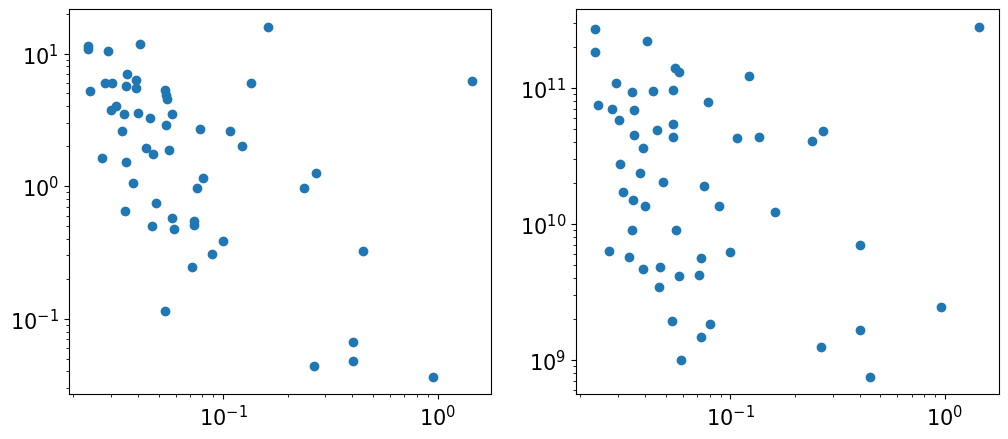

In [116]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5))
ax1.scatter(sample["v_asym_tot"].to_numpy(),bpt["SFR, dust corrected"].to_numpy())
ax2.scatter(sample['v_asym_tot'].to_numpy(),prospect["StellarMass_median"].to_numpy())
ax1.set_xscale("log")
ax1.set_yscale("log")
ax2.set_xscale("log")
ax2.set_yscale("log")
plt.show()

PearsonRResult(statistic=-0.5290493734909836, pvalue=3.907896424941457e-05)
PearsonRResult(statistic=-0.27122717805209584, pvalue=0.04727512091310414)


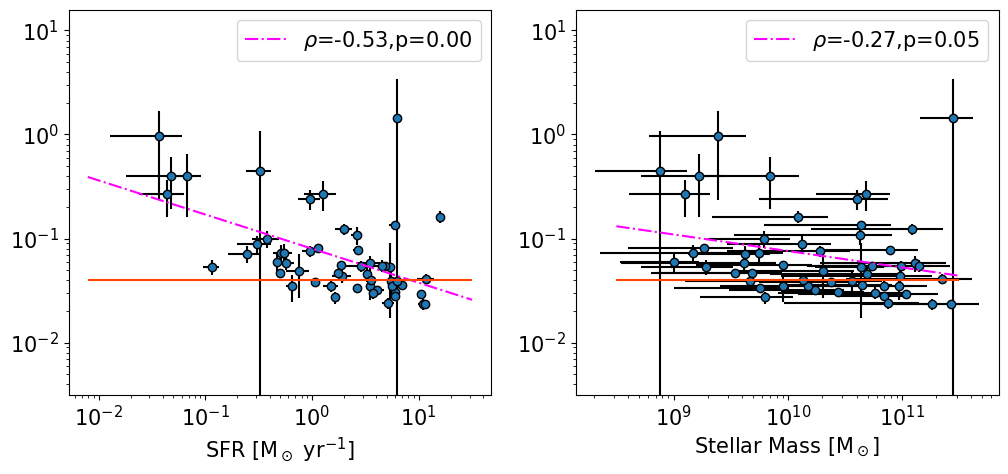

In [117]:
import scipy
x = np.log10(sample['v_asym_tot'].to_numpy())
y = np.log10(bpt['SFR, dust corrected'].to_numpy())
z = np.log10(prospect["StellarMass_median"].to_numpy())
x = x[~np.isnan(y)]
z = z[~np.isnan(y)]
y = y[~np.isnan(y)]
y = y[~np.isnan(x)]
z = z[~np.isnan(x)]
x = x[~np.isnan(x)]
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5))
lt = [y,z]
for i in range(2):
    res = scipy.stats.linregress(lt[i],x)
    per = scipy.stats.pearsonr(lt[i],x)
    print(per)
    if i==0:
        ax1.scatter(bpt["SFR, dust corrected"].to_numpy(),sample["v_asym_tot"].to_numpy(),zorder=2,ec="k")
        ax1.errorbar(bpt["SFR, dust corrected"].to_numpy(),sample["v_asym_tot"].to_numpy(), xerr=bpt["SFR_err"].to_numpy(),yerr=sample['v_asym_tot_err'].to_numpy(), fmt=".k",zorder=1)
        xx = np.logspace(-2.1,1.5)
        ax1.plot(xx,(10**res[1])*(xx**res[0]),ls="dashdot",zorder=2,color="magenta",label=r"$\rho$="+f"{per[0]:.2f}"+r",p="+f"{per[1]:.2f}")
        ax1.set_xscale("log")
        ax1.set_yscale("log")
        ax1.set_ylim(10**(-2.5),10**(1.2))
        ax1.hlines(0.04,xx[0],xx[-1],zorder=2,color="orangered")
        ax1.legend()
        ax1.set_xlabel(r"SFR [M$_\odot$ yr$^{-1}$]")
    if i==1:
        ax2.scatter(prospect["StellarMass_median"].to_numpy(),sample['v_asym_tot'].to_numpy(),zorder=2,ec="k")
        ax2.errorbar(prospect["StellarMass_median"].to_numpy(),sample["v_asym_tot"].to_numpy(), xerr=prospect["StellarMass_16"].to_numpy(),
                     yerr=sample['v_asym_tot_err'].to_numpy(), fmt=".k",zorder=1)
        xx = np.logspace(8.5,11.5)
        ax2.plot(xx,(10**res[1])*(xx**res[0]),ls="dashdot",zorder=2,color="magenta",label=r"$\rho$="+f"{per[0]:.2f}"+r",p="+f"{per[1]:.2f}")
        ax2.set_xscale("log")
        ax2.set_yscale("log")
        ax2.set_ylim(10**(-2.5),10**(1.2))
        ax2.hlines(0.04,xx[0],xx[-1],zorder=2,color="orangered")
        ax2.legend()
        ax2.set_xlabel(r"Stellar Mass [M$_\odot$]")
plt.show()

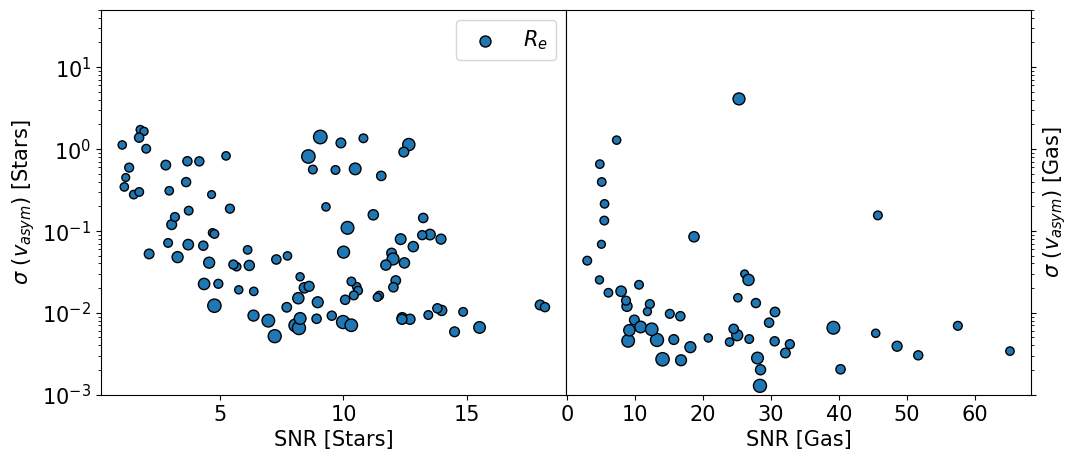

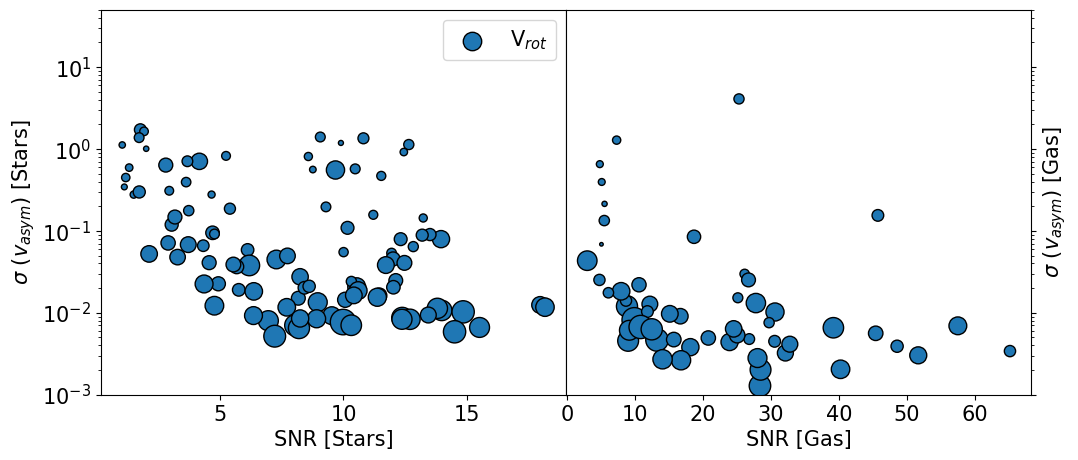

In [118]:
sample = pd.read_csv("MAGPI_csv/MAGPI_kinemetry_sample_1Re.csv")
bpt = pd.read_csv("MAGPI_csv/MAGPI_kinemetry_sample_BPT.csv")
bpt = bpt[bpt["MAGPIID"].isin(sample["MAGPIID"])]
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5),sharey="row")
ax1.scatter(sample["SNR_s"],sample["v_asym_s_err"],ec="k",s=bpt["re, kpc"],label=r"$R_e$")
ax2.scatter(sample["SNR_g"],sample["v_asym_g_err"],ec="k",s=bpt["re, kpc"])
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_ylabel(r"$\sigma$ $(v_{asym})$ [Stars]")
ax1.set_xlabel(r"SNR [Stars]")
ax2.set_xlabel("SNR [Gas]")
ax2.yaxis.tick_right()
ax2.set_ylabel(r"$\sigma$ $(v_{asym})$ [Gas]")
ax2.yaxis.set_label_position("right")
ax1.set_ylim(1e-3,5e1)
ax1.legend()
plt.subplots_adjust(wspace=0)
plt.savefig("plots/v_asym_err_size.pdf",bbox_inches="tight")

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5),sharey="row")
ax1.scatter(sample["SNR_s"],sample["v_asym_s_err"],ec="k",s=sample["V_rot_s"],label=r"V$_{rot}$")
ax2.scatter(sample["SNR_g"],sample["v_asym_g_err"],ec="k",s=sample["V_rot_g"])
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_ylabel(r"$\sigma$ $(v_{asym})$ [Stars]")
ax1.set_xlabel(r"SNR [Stars]")
ax2.set_xlabel("SNR [Gas]")
ax2.yaxis.tick_right()
ax2.set_ylabel(r"$\sigma$ $(v_{asym})$ [Gas]")
ax2.yaxis.set_label_position("right")
ax1.legend()
ax1.set_ylim(1e-3,5e1)
plt.subplots_adjust(wspace=0)
plt.savefig("plots/v_asym_err_vrot.pdf",bbox_inches="tight")

In [119]:
prospect = pd.read_csv("MAGPI_csv/MAGPI_ProSpectCat_v0.1.csv")
prospect = prospect[prospect["MAGPIID"].isin(sample["MAGPIID"])]
galfit = pd.read_csv("MAGPI_csv/MAGPI_GalfitSersicCat_v0.1.csv")
galfit = galfit[galfit["MAGPIID"].isin(sample["MAGPIID"])]
dl = cosmo.luminosity_distance(z=galfit["z"].to_numpy()).to(u.kpc).value
dl = (galfit["re"].to_numpy()/3600)*dl
mass = prospect["StellarMass_median"].to_numpy()
asym_s = sample["v_asym_s"].to_numpy()
asym_g = sample["v_asym_g"].to_numpy()
marks=[]
for i in range(len(asym_s)):
    if asym_s[i]>0.04:
        marks.append("^")
    else:
        marks.append("v")

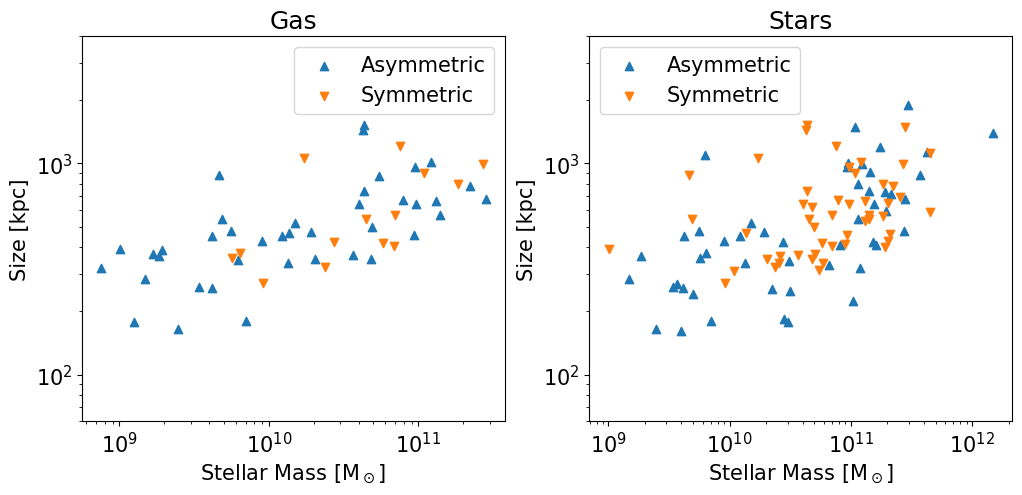

In [120]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
ax1.scatter(mass[asym_g>0.04],dl[asym_g>0.04],marker="^",label="Asymmetric")
ax1.scatter(mass[asym_g<0.04],dl[asym_g<0.04],marker="v",label="Symmetric")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_ylim(6e1,4e3)
ax1.legend()
#plt.colorbar(p,ax=ax)
ax2.scatter(mass[asym_s>np.nanmedian(asym_s)],dl[asym_s>np.nanmedian(asym_s)],marker="^",label="Asymmetric")
ax2.scatter(mass[asym_s<np.nanmedian(asym_s)],dl[asym_s<np.nanmedian(asym_s)],marker="v",label="Symmetric")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_ylim(6e1,4e3)
ax2.legend()
ax1.set_title("Gas")
ax2.set_title("Stars")
for ax in [ax1,ax2]:
    ax.set_xlabel(r"Stellar Mass [M$_\odot$]")
    ax.set_ylabel(r"Size [kpc]")
#plt.colorbar(p,ax=ax)
plt.show()

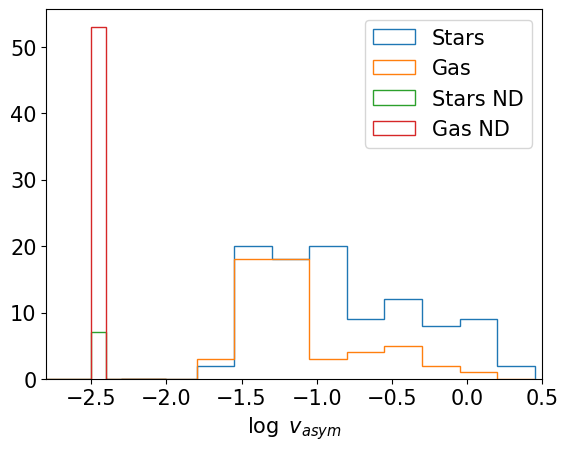

In [130]:
asym_s = sample["v_asym_s"].to_numpy()
asym_g = sample["v_asym_g"].to_numpy()
asym_s[np.isnan(asym_s)]=10**(-2.5)
asym_s[asym_s==0]=10**(-2.5)
asym_g[np.isnan(asym_g)]=10**(-2.5)
fig,ax = plt.subplots()
ax.hist(np.log10(asym_s[asym_s>10**(-2.3)]),histtype="step",bins=np.arange(-2.3,0.5,0.25),label="Stars")
ax.hist(np.log10(asym_g[asym_g>10**(-2.3)]),histtype="step",bins=np.arange(-2.3,0.5,0.25),label="Gas")
ax.hist(np.log10(asym_s[asym_s<10**(-2.3)]),histtype="step",label="Stars ND")
ax.hist(np.log10(asym_g[asym_g<10**(-2.3)]),histtype="step",label="Gas ND")
ax.set_xlabel(r"$\log$ v$_{asym}$")
ax.legend()
ax.set_xlabel(r"$\log$ $v_{asym}$")
ax.set_xlim(-2.8,0.5)
plt.savefig("plots/v_asym_hist_s_g.pdf",bbox_inches="tight")

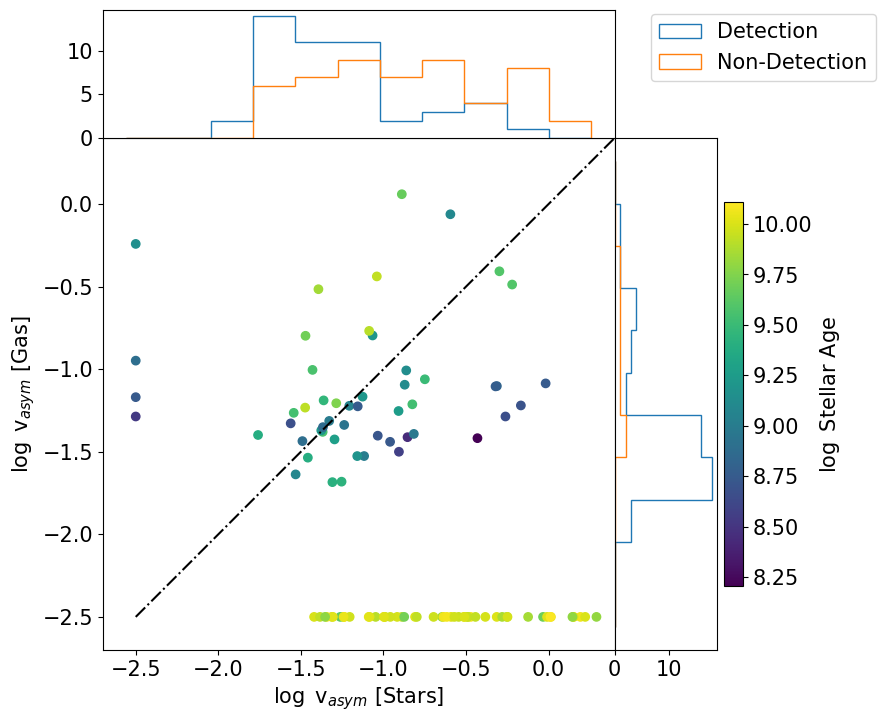

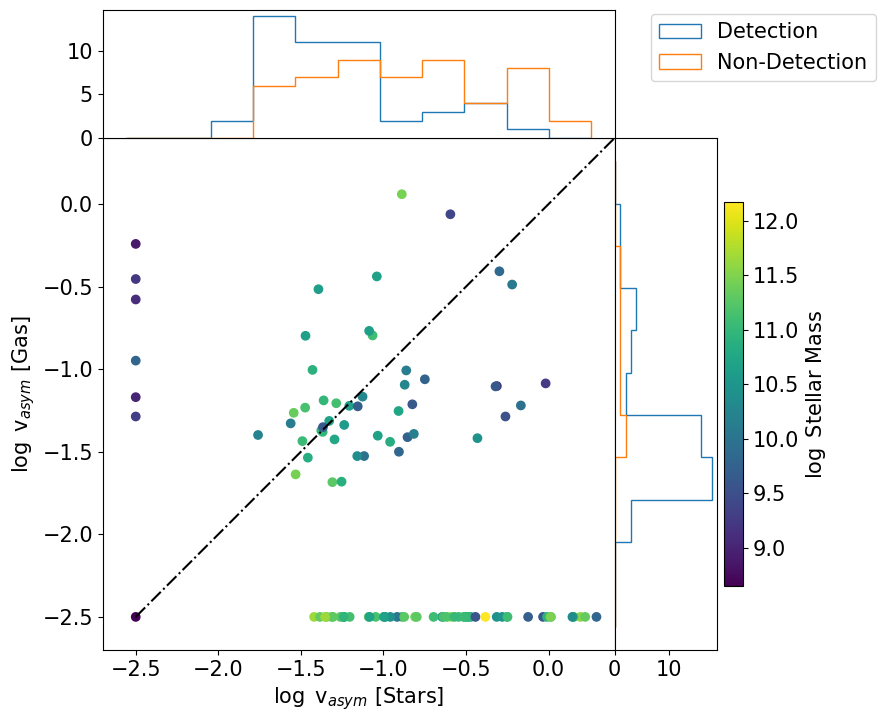

In [132]:
ssp = pd.read_csv("MAGPI_csv/MAGPI_ApertureSpectra_StellarPops_V1.0_SPV.csv")
ssp = ssp[ssp["MAGPIID"].isin(sample["MAGPIID"])]
fig = plt.figure(figsize=(8,8))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.0, hspace=0.0)
ax = fig.add_subplot(gs[1,0])
p=ax.scatter(np.log10(asym_s),np.log10(asym_g),c=ssp["logage_LW_1.5re"].to_numpy())
# ax.set_xscale("log")
# ax.set_yscale("log")
ax.plot(np.linspace(-2.5,0.5),np.linspace(-2.5,0.5),ls="dashdot",color="k")
ax.set_xlabel(r"$\log$ v$_{asym}$ [Stars]")
ax.set_ylabel(r"$\log$ v$_{asym}$ [Gas]")
ax.set_xlim(-2.7,0.4)
ax.set_ylim(-2.7,0.4)
ax_histx = fig.add_subplot(gs[0,0])
ax_histx.hist(np.log10(asym_s[asym_g>10**(-2.3)]),histtype="step",bins=np.arange(-2.3,0.5,0.25),label="Detection")
ax_histx.hist(np.log10(asym_s[asym_g<10**(-2.3)]),histtype="step",bins=np.arange(-2.3,0.5,0.25),label="Non-Detection")
ax_histx.set_xticks([])
ax_histx.legend(bbox_to_anchor=(1.05,1.05))
ax_histy = fig.add_subplot(gs[1,1])
ax_histy.hist(np.log10(asym_g[asym_s>10**(-2.3)]),histtype="step",orientation="horizontal",bins=np.arange(-2.3,0.5,0.25))
ax_histy.hist(np.log10(asym_g[asym_s<10**(-2.3)]),histtype="step",orientation="horizontal",bins=np.arange(-2.3,0.5,0.25))
ax_histy.set_yticks([])
plt.colorbar(p,ax=ax_histy,label=r"$\log$ Stellar Age")
plt.savefig("plots/paper2/v_asym_s_g_age.pdf",bbox_inches="tight")

fig = plt.figure(figsize=(8,8))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.0, hspace=0.0)
ax = fig.add_subplot(gs[1,0])
p=ax.scatter(np.log10(asym_s),np.log10(asym_g),c=np.log10(prospect["StellarMass_median"].to_numpy()))
# ax.set_xscale("log")
# ax.set_yscale("log")
ax.plot(np.linspace(-2.5,0.5),np.linspace(-2.5,0.5),ls="dashdot",color="k")
ax.set_xlabel(r"$\log$ v$_{asym}$ [Stars]")
ax.set_ylabel(r"$\log$ v$_{asym}$ [Gas]")
ax.set_xlim(-2.7,0.4)
ax.set_ylim(-2.7,0.4)
ax_histx = fig.add_subplot(gs[0,0])
ax_histx.hist(np.log10(asym_s[asym_g>10**(-2.3)]),histtype="step",bins=np.arange(-2.3,0.5,0.25),label="Detection")
ax_histx.hist(np.log10(asym_s[asym_g<10**(-2.3)]),histtype="step",bins=np.arange(-2.3,0.5,0.25),label="Non-Detection")
ax_histx.set_xticks([])
ax_histx.legend(bbox_to_anchor=(1.05,1.05))
ax_histy = fig.add_subplot(gs[1,1])
ax_histy.hist(np.log10(asym_g[asym_s>10**(-2.3)]),histtype="step",orientation="horizontal",bins=np.arange(-2.3,0.5,0.25))
ax_histy.hist(np.log10(asym_g[asym_s<10**(-2.3)]),histtype="step",orientation="horizontal",bins=np.arange(-2.3,0.5,0.25))
ax_histy.set_yticks([])
plt.colorbar(p,ax=ax_histy,label=r"$\log$ Stellar Mass")
plt.savefig("plots/paper2/v_asym_s_g_mass.pdf",bbox_inches="tight")

/var/folders/nl/v2f_l95j0jx701ctszdv_thr0000gp/T/ipykernel_91357/183346806.py:22: RuntimeWarning: divide by zero encountered in divide
  ax1.scatter(np.log10(nii/ ha), np.log10(oiii / hb), s=2, c="k")
/var/folders/nl/v2f_l95j0jx701ctszdv_thr0000gp/T/ipykernel_91357/183346806.py:22: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(nii/ ha), np.log10(oiii / hb), s=2, c="k")
/var/folders/nl/v2f_l95j0jx701ctszdv_thr0000gp/T/ipykernel_91357/183346806.py:26: RuntimeWarning: divide by zero encountered in divide
  ax2.scatter(np.log10(sii / ha), np.log10(oiii / hb), s=2, c="k")
/var/folders/nl/v2f_l95j0jx701ctszdv_thr0000gp/T/ipykernel_91357/183346806.py:26: RuntimeWarning: invalid value encountered in divide
  ax2.scatter(np.log10(sii / ha), np.log10(oiii / hb), s=2, c="k")
/var/folders/nl/v2f_l95j0jx701ctszdv_thr0000gp/T/ipykernel_91357/183346806.py:26: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(sii / ha), np.log10(oiii / hb), s=2, c=

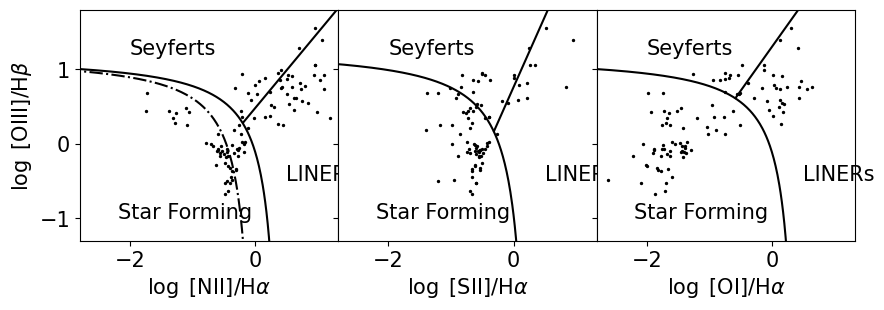

In [123]:
bpt = pd.read_csv("MAGPI_csv/MAGPI_kinemetry_sample_BPT.csv")
ha = bpt["Ha"].to_numpy()
hb = bpt["Hb"].to_numpy()
oiii = bpt["[OIII]5008"].to_numpy()
oi = bpt["[OI]6302"].to_numpy()
nii = bpt["[NII]6585"].to_numpy()
sii = bpt["[SII]6718"].to_numpy()
xx = np.arange(-4, 0.25, 0.01)
yy = 1.19 + (0.61 / (xx - 0.47))
nn = np.arange(-3, 0.03, 0.01)
mm = 1.19 + (0.61 / (nn - 0.05))
vv = 1.30 + (0.72 / (xx - 0.32))
dd = 1.19 + (0.61 / (xx - 0.47))
cc = np.arange(-0.31, 2, 0.01)
pp = 1.89 * cc + 0.76
hh = np.arange(-0.58, 2, 0.01)
ll = 1.18 * hh + 1.30
jj = np.arange(-0.19, 2, 0.01)
kk = 1.01 * jj + 0.48

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey="row", figsize=(10, 3))
ax1.scatter(np.log10(nii/ ha), np.log10(oiii / hb), s=2, c="k")
ax1.plot(xx, yy, color="k")
ax1.plot(nn, mm, color="k", ls="dashdot")
ax1.plot(jj, kk, color="k")
ax2.scatter(np.log10(sii / ha), np.log10(oiii / hb), s=2, c="k")
ax2.plot(xx, vv, color="k")
ax2.plot(cc, pp, color="k")
ax3.scatter(np.log10(oi / ha), np.log10(oiii / hb), s=2, c="k")
ax3.plot(xx, dd, color="k")
ax3.plot(hh, ll, color="k")
for ax in [ax1, ax2, ax3]:
    ax.text(x=0.5, y=-0.5, s="LINERs")
    ax.text(x=-2, y=1.2, s="Seyferts")
    ax.text(x=-2.2, y=-1.0, s="Star Forming")
    ax.set_ylim(-1.3, 1.8)
    ax.set_xlim(-2.8, 1.33)
ax1.set_xlabel(r"$\log$ [NII]/H$\alpha$")
ax2.set_xlabel(r"$\log$ [SII]/H$\alpha$")
ax3.set_xlabel(r"$\log$ [OI]/H$\alpha$")
ax1.set_ylabel(r"$\log$ [OIII]/H$\beta$")
plt.subplots_adjust(wspace=0)
plt.savefig("plots/paper2/BPT.pdf", bbox_inches="tight")

In [124]:
len(bpt[bpt["type(sf=1, sy=2, ln=3) SII"]==2])

18

In [125]:
bpt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   MAGPIID                           107 non-null    int64  
 1   Ha                                107 non-null    float64
 2   Ha_err                            107 non-null    float64
 3   Hb                                107 non-null    float64
 4   [OI]6302                          107 non-null    float64
 5   [OIII]5008                        107 non-null    float64
 6   [NII]6585                         107 non-null    float64
 7   [SII]6718                         107 non-null    float64
 8   type(sf+AGN=0, sf=1, sy=2, ln=3)  107 non-null    float64
 9   type(sf=1, sy=2, ln=3) SII        107 non-null    float64
 10  SFR, dust corrected               107 non-null    float64
 11  SFR_err                           107 non-null    float64
 12  re, arcs

In [126]:
morph = pd.read_csv("MAGPI_csv/MAGPI_VisClassStats.csv")
morph = morph[morph["MAGPIID"].isin(sample["MAGPIID"])]

In [127]:
for i,j in zip(morph["MAGPIID"].to_numpy(),morph["muBarFlag"].to_numpy()):
    if j>0:
        print(f"{i}, {j:.2f}")

1204198199, 0.09
1207181305, 0.08
1207197197, 0.55
1209131247, 0.09
1209197197, 0.36
1501176107, 0.09
1506279269, 0.42
1508197198, 0.36
1511283231, 0.36
1525170222, 0.18
1527196197, 0.09
1528197197, 0.36
1533176049, 0.27
1533197198, 0.09
1534198197, 0.09
2304279199, 0.09
2307145281, 0.18
2308186140, 0.08
2310199196, 0.18
2310313103, 0.09


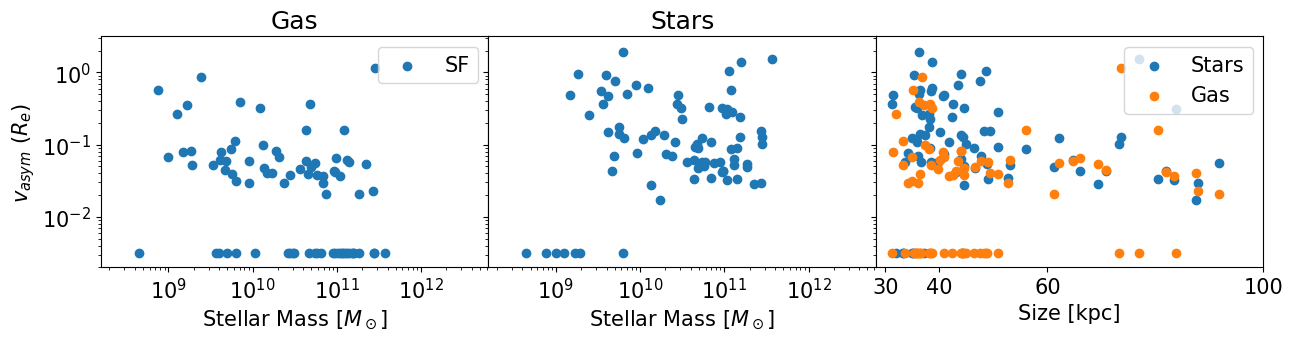

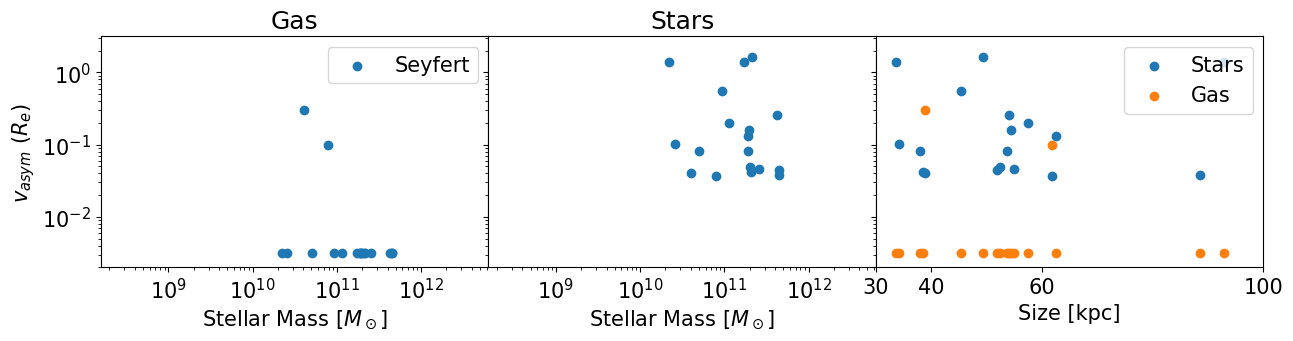

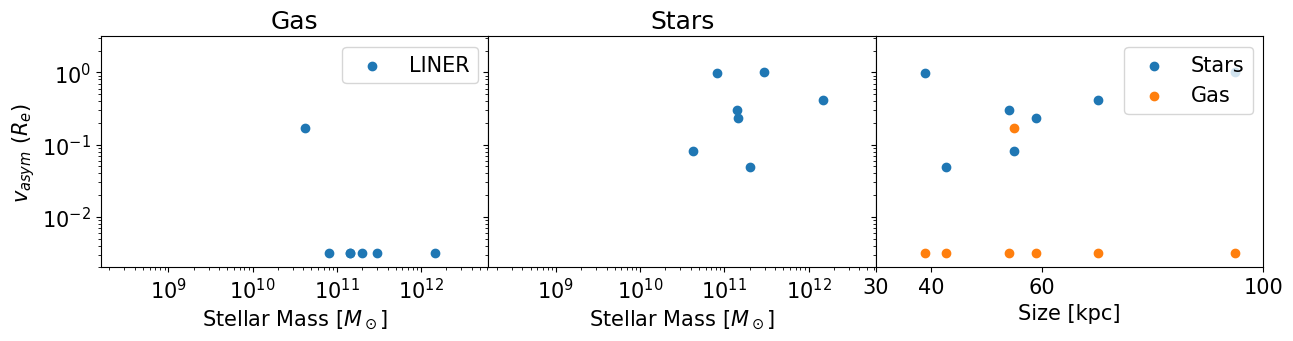

In [172]:
fig,(ax1,ax2,ax3) =plt.subplots(1,3,figsize=(15,3),sharey="row")
sample = pd.read_csv("MAGPI_csv/MAGPI_kinemetry_sample_1re.csv")
prospect = pd.read_csv("MAGPI_csv/MAGPI_ProSpectCat_v0.1.csv")
bpt = pd.read_csv("MAGPI_csv/MAGPI_kinemetry_sample_BPT.csv")
sample = sample[sample["MAGPIID"].isin(bpt[bpt["type(sf=1, sy=2, ln=3) SII"]==1]["MAGPIID"])]
bpt = bpt[bpt["MAGPIID"].isin(sample["MAGPIID"])]
prospect = prospect[prospect["MAGPIID"].isin(sample["MAGPIID"])]
mass = prospect["StellarMass_median"].to_numpy()

asym_s = sample["v_asym_s"].to_numpy()
asym_g = sample["v_asym_g"].to_numpy()
asym_s[np.isnan(asym_s)]=10**(-2.5)
asym_s[asym_s==0]=10**(-2.5)
asym_g[np.isnan(asym_g)]=10**(-2.5)

ax1.scatter(mass,asym_g,label="SF")
ax2.scatter(mass,asym_s)
ax3.scatter(bpt["re, kpc"],asym_s,label="Stars")
ax3.scatter(bpt["re, kpc"],asym_g,label="Gas")
ax3.set_xticks([30,40,60,100])
ax3.set_xticklabels(['30','40','60','100'])
ax3.set_yscale("log")
ax1.set_title("Gas")
ax2.set_title("Stars")
ax1.legend(loc="upper right")
ax3.legend(loc="upper right")
ax3.set_ylim(10**(-2.7),10**(0.5))
for ax in [ax1,ax2]:
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax1.set_ylabel(r"$v_{asym}$ ($R_e$)")
    ax.set_xlabel(r"Stellar Mass [$M_\odot$]")
    ax3.set_xlabel(r"Size [kpc]")
    ax.set_xlim(10**(8.2),10**(12.8))
    ax.set_ylim(10**(-2.7),10**(0.5))
plt.subplots_adjust(wspace=0)
plt.show()

fig,(ax1,ax2,ax3) =plt.subplots(1,3,figsize=(15,3),sharey="row")
sample = pd.read_csv("MAGPI_csv/MAGPI_kinemetry_sample_1re.csv")
prospect = pd.read_csv("MAGPI_csv/MAGPI_ProSpectCat_v0.1.csv")
bpt = pd.read_csv("MAGPI_csv/MAGPI_kinemetry_sample_BPT.csv")
sample = sample[sample["MAGPIID"].isin(bpt[bpt["type(sf=1, sy=2, ln=3) SII"]==2]["MAGPIID"])]
bpt = bpt[bpt["MAGPIID"].isin(sample["MAGPIID"])]
prospect = prospect[prospect["MAGPIID"].isin(sample["MAGPIID"])]
mass = prospect["StellarMass_median"].to_numpy()
asym_s = sample["v_asym_s"].to_numpy()
asym_g = sample["v_asym_g"].to_numpy()
asym_s[np.isnan(asym_s)]=10**(-2.5)
asym_s[asym_s==0]=10**(-2.5)
asym_g[np.isnan(asym_g)]=10**(-2.5)

ax1.scatter(mass,asym_g,label="Seyfert")
ax2.scatter(mass,asym_s)
ax3.scatter(bpt["re, kpc"],asym_s,label="Stars")
ax3.scatter(bpt["re, kpc"],asym_g,label="Gas")
ax3.set_xticks([30,40,60,100])
ax3.set_xticklabels(['30','40','60','100'])
ax3.set_yscale("log")
ax1.set_title("Gas")
ax2.set_title("Stars")
ax1.legend(loc="upper right")
ax3.legend(loc="upper right")
ax3.set_ylim(10**(-2.7),10**(0.5))
for ax in [ax1,ax2]:
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax1.set_ylabel(r"$v_{asym}$ ($R_e$)")
    ax.set_xlabel(r"Stellar Mass [$M_\odot$]")
    ax3.set_xlabel(r"Size [kpc]")
    ax.set_xlim(10**(8.2),10**(12.8))
    ax.set_ylim(10**(-2.7),10**(0.5))
plt.subplots_adjust(wspace=0)
plt.show()

fig,(ax1,ax2,ax3) =plt.subplots(1,3,figsize=(15,3),sharey="row")
sample = pd.read_csv("MAGPI_csv/MAGPI_kinemetry_sample_1re.csv")
prospect = pd.read_csv("MAGPI_csv/MAGPI_ProSpectCat_v0.1.csv")
bpt = pd.read_csv("MAGPI_csv/MAGPI_kinemetry_sample_BPT.csv")
sample = sample[sample["MAGPIID"].isin(bpt[bpt["type(sf=1, sy=2, ln=3) SII"]==3]["MAGPIID"])]
bpt = bpt[bpt["MAGPIID"].isin(sample["MAGPIID"])]
prospect = prospect[prospect["MAGPIID"].isin(sample["MAGPIID"])]
mass = prospect["StellarMass_median"].to_numpy()
asym_s = sample["v_asym_s"].to_numpy()
asym_g = sample["v_asym_g"].to_numpy()
asym_s[np.isnan(asym_s)]=10**(-2.5)
asym_s[asym_s==0]=10**(-2.5)
asym_g[np.isnan(asym_g)]=10**(-2.5)

ax1.scatter(mass,asym_g,label="LINER")
ax2.scatter(mass,asym_s)
ax3.scatter(bpt["re, kpc"],asym_s,label="Stars")
ax3.scatter(bpt["re, kpc"],asym_g,label="Gas")
ax3.set_xticks([30,40,60,100])
ax3.set_xticklabels(['30','40','60','100'])
ax3.set_yscale("log")
ax1.set_title("Gas")
ax2.set_title("Stars")
ax1.legend(loc="upper right")
ax3.legend(loc="upper right")
ax3.set_ylim(10**(-2.7),10**(0.5))
for ax in [ax1,ax2]:
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax1.set_ylabel(r"$v_{asym}$ ($R_e$)")
    ax.set_xlim(10**(8.2),10**(12.8))
    ax.set_ylim(10**(-2.7),10**(0.5))
    ax.set_xlabel(r"Stellar Mass [$M_\odot$]")
    ax3.set_xlabel(r"Size [kpc]")
plt.subplots_adjust(wspace=0)
plt.show()